# Imports and loading of data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import math
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.probability import FreqDist
from wordcloud import WordCloud
import collections
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import files
import string
punctuation = list(string.punctuation)
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.graph_objs as go
from sklearn.feature_selection import mutual_info_classif
from nltk.sentiment import SentimentIntensityAnalyzer
import re
import string
from textblob import TextBlob
from nltk.stem import PorterStemmer
import seaborn as sns
import plotly.express as px

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Coursework_2/opinion_fact_news.csv')
stop_words = set(stopwords.words('english'))

In [ ]:
newdf = df
newdf['all_text'] = newdf['title'] + " " + newdf['body']
newdf.head(n=3)
df

,title,body,label,all_text
0,Is Bernie Sanders really happening?,Watching Sanders surge to the front of the pac...,opinion,Is Bernie Sanders really happening? Watching S...
1,The London terror attack would’ve been much wo...,Two people were stabbed in Sunday’s attack in ...,opinion,The London terror attack would’ve been much wo...
2,The Super Bowl poses the question: What’s more...,But one debate overshadowed the rest: whether ...,opinion,The Super Bowl poses the question: What’s more...
3,"On health care, is Trump malicious or just inc...",While Democrats debate the best path to univer...,opinion,"On health care, is Trump malicious or just inc..."
4,What ever happened to that ‘head on a pike’ st...,It was when Adam Schiff made a reference to so...,opinion,What ever happened to that ‘head on a pike’ st...
...,...,...,...,...
9995,PetroChina tops Singapore's shrinking list of ...,"SINGAPORE, Jan 29 (Reuters) - PetroChina’s Sin...",fact,PetroChina tops Singapore's shrinking list of ...
9996,Tencent extends holiday for China employees ti...,BEIJING (Reuters) - Chinese gaming giant Tence...,fact,Tencent extends holiday for China employees ti...
9997,Tokyo 2020 unveils sustainable athletes villag...,TOKYO (Reuters) - When the world’s top athlete...,fact,Tokyo 2020 unveils sustainable athletes villag...
9998,"Novartis predicts 2020 growth as Cosentyx, Zol...",FILE PHOTO: The company's logo is seen at the ...,fact,"Novartis predicts 2020 growth as Cosentyx, Zol..."


In [ ]:
#grouped = newdf.groupby('label')['all_text'].sum().reset_index() 

In [ ]:
#grouped['all_text'][0]

#Inital Analysis

<Axes: >

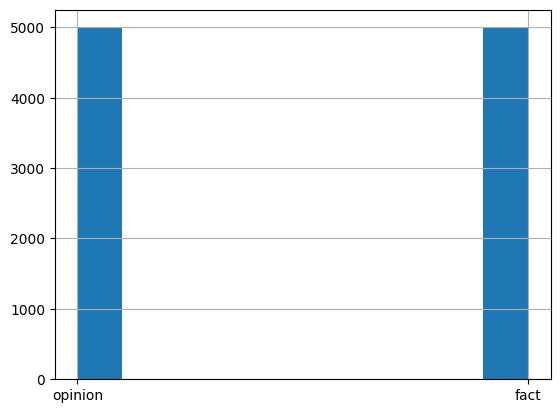

In [ ]:
#Balanced Data
df.value_counts("label")
df.label.hist()

In [ ]:
#length of texts
df["tokenized"]=df.all_text.apply(lambda x: x.lower())
df["tokenized"]=df.tokenized.apply(word_tokenize)


In [ ]:
def text_length(tokenized_list):
  return(len(tokenized_list))
newnames = {'wide_variable_0':'Opinion', 'wide_variable_1': 'Fact'}
df["corpus_length"]=df["tokenized"].apply(text_length)


fig1=px.histogram(x=[df["corpus_length"][df["label"]=="opinion"], df["corpus_length"][df["label"]=="fact"]], barmode="overlay", height=500, width=800, title = "Length of Tokenized Text")
fig1.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig1.show()


fig2=px.histogram(x=[df[df["label"]=="opinion"].nsmallest(4985, "corpus_length")["corpus_length"], df[df["label"]=="fact"].nsmallest(4985, "corpus_length")["corpus_length"]], barmode="overlay", height=500, width=800, title = "Length of Tokenized Text (Zoomed)")

fig2.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig2.show()


In [ ]:
counts=df[["label", "corpus_length"]].groupby("label").sum().reset_index()

counts.corpus_length[1]/counts.corpus_length[0]

1.8195152806853732

#Sentiment Analysis

## Vader

In [ ]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stem the tokens
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Join the tokens back into a string
    text = ' '.join(tokens)
    
    return text
  
df['preprocessed'] = df['all_text'].apply(preprocess_text)




In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

sentiment_scores = df['all_text'].apply(lambda x: analyzer.polarity_scores(x))
df['vader_sentiment_pos'] = sentiment_scores.apply(lambda x: x['pos'])
df['vader_sentiment_neg'] = sentiment_scores.apply(lambda x: x['neg'])
df['vader_sentiment_neu'] = sentiment_scores.apply(lambda x: x['neu'])
df['vader_sentiment_compound'] = sentiment_scores.apply(lambda x: x['compound'])


In [ ]:
import plotly.express as px

column="vader_sentiment_compound"
#this is literally just so the legend on the plot looks nice
quickdf=pd.DataFrame(list(df[column][df["label"]=="fact"]), columns=["Fact"])
quickdf["Opinion"]=list(df[column][df["label"]=="opinion"])#, df[column][df["label"]=="fact"]])))#,columns =['Opinion', 'Fact'])


fig1=px.histogram(data_frame=quickdf, x=["Opinion","Fact"], barmode="overlay", height=500, width=800, title = "Vader Sentiment Results")
fig1.show()


In [ ]:
from scipy.stats import kstest
from sklearn.feature_selection import SelectKBest, f_classif

##Testing if the distributions are different

kstest(rvs=quickdf["Fact"], cdf=quickdf["Opinion"])

KstestResult(statistic=0.1328, pvalue=7.866633848570472e-39, statistic_location=0.9656, statistic_sign=1)

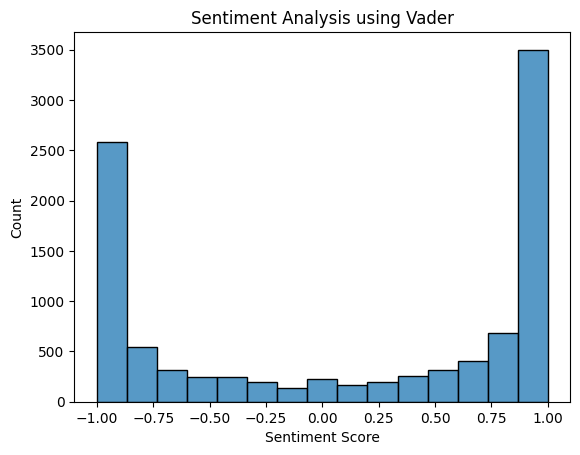

In [ ]:
sns.histplot(df['vader_sentiment_compound'], kde=False)
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.title('Sentiment Analysis using Vader')
plt.show()

## TextBlob

In [ ]:
# Define a function to get the sentiment polarity using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    return polarity

# Apply the function to the 'all_text' column and create a new column 'sentiment'
df['sentiment_score_textBlob'] = df['preprocessed'].apply(get_sentiment)

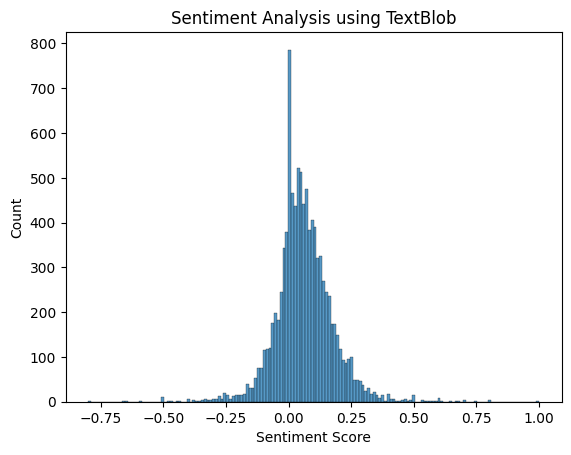

In [ ]:
sns.histplot(df['sentiment_score_textBlob'], kde=False)
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.title('Sentiment Analysis using TextBlob')
plt.show()

In [ ]:
import plotly.express as px

column="sentiment_score_textBlob"
#this is literally just so the legend on the plot looks nice
quickdf=pd.DataFrame(list(df[column][df["label"]=="fact"]), columns=["Fact"])
quickdf["Opinion"]=list(df[column][df["label"]=="opinion"])#, df[column][df["label"]=="fact"]])))#,columns =['Opinion', 'Fact'])


fig1=px.histogram(data_frame=quickdf, x=["Opinion","Fact"], barmode="overlay", height=500, width=800, title = "Vader Sentiment Results")
fig1.show()


## Visualizations

In [ ]:
df.head(n=3)

,title,body,label,all_text,tokenized,corpus_length,preprocessed,vader_sentiment_pos,vader_sentiment_neg,vader_sentiment_neu,vader_sentiment_compound,sentiment_score_textBlob
0,Is Bernie Sanders really happening?,Watching Sanders surge to the front of the pac...,opinion,Is Bernie Sanders really happening? Watching S...,"[is, bernie, sanders, really, happening, ?, wa...",879,berni sander realli happen watch sander surg f...,0.092,0.076,0.832,0.9612,0.092886
1,The London terror attack would’ve been much wo...,Two people were stabbed in Sunday’s attack in ...,opinion,The London terror attack would’ve been much wo...,"[the, london, terror, attack, would, ’, ve, be...",450,london terror attack would ’ much wors assail ...,0.016,0.206,0.778,-0.9973,-0.098359
2,The Super Bowl poses the question: What’s more...,But one debate overshadowed the rest: whether ...,opinion,The Super Bowl poses the question: What’s more...,"[the, super, bowl, poses, the, question, :, wh...",817,super bowl pose question ’ obscen sex sexism o...,0.172,0.076,0.751,0.9981,0.096219


In [ ]:
grouped_vader = df.groupby('label')['vader_sentiment_compound'].median()
grouped_vader

label
fact       0.3400
opinion    0.5632
Name: vader_sentiment_compound, dtype: float64

In [ ]:
grouped_blob = df.groupby('label')['sentiment_score_textBlob'].median()
grouped_blob

label
fact       0.039669
opinion    0.065017
Name: sentiment_score_textBlob, dtype: float64

###Feature Selection of Sentiment Analysis Scores

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X2=df[["vader_sentiment_pos",	"vader_sentiment_neg",	"vader_sentiment_neu","vader_sentiment_compound", "sentiment_score_textBlob"]]
X3=df[["vader_sentiment_pos",	"vader_sentiment_neg",	"vader_sentiment_neu"]]
y=df["label"].factorize()



# Load the dataset

# Create a logistic regression model
model = LogisticRegression()

# Use RFE to select the top 10 features
rfe = RFE(model, n_features_to_select=1)
rfe.fit(X2, y[0])

# Print the selected features
print(rfe.ranking_)
#output is 2 3 1 6 4 5 --- the top 3 predictors are vader
#

[2 3 1 5 4]


In [ ]:
import statsmodels.api as sm

# Fit logistic regression model
logit_model = sm.Logit(y[0], X3) #y(0) gets the features as 1s and 0s
result = logit_model.fit()

# Print summary of the model
print(result.summary())

# Test for significance of predictor variables
p_values = result.pvalues

Optimization terminated successfully.
         Current function value: 0.565696
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Tue, 18 Apr 2023   Pseudo R-squ.:                  0.1839
Time:                        08:50:07   Log-Likelihood:                -5657.0
converged:                       True   LL-Null:                       -6931.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
vader_sentiment_pos   -17.0605      0.531    -32.120      0.000     -18.102     -16.019
va

# Feature Selection

##Functions

In [ ]:
def doc_freq_dict2(prepro_col, word_list="All"):
  """This function returns how many documents (from the preprocessed column) each word in the word list appear

  prepro_col: should be a tokenized column of words
  word_list: list of words to calculate the frequency of"""
  all_word_dict = {}
  word_dict={}
  for text in prepro_col:
    #print(set(text))
    for word in set(text): #uniqueness
      if word not in all_word_dict:
        all_word_dict[word] = 0
      all_word_dict[word]+=1
  if word_list=="All":
    return(all_word_dict)
  else:
    for word in word_list:
      try: 
        word_dict[word]=all_word_dict[word]
      except:
        print(word,"not present")
    return(word_dict)

def graphDisplay(A_word_counts, B_word_counts, spec_word_list, rot=0, A="A", B="B", displays=20,lilmin=0):
  """Function that compares the appearences of  given words in two classes of documents. 
  INPUT: 
  A_word_counts: 
  B_word_counts:
  spec_word_list:
  A_len
  B_len
  rot,A,B,displays, lilmin are graphical parameters

  OUTPUT:
  
  """
  n=spec_word_list #number of words we're dealing with
  A_spec = {k: A_word_counts[k] for k in spec_word_list}
  B_spec = {k: B_word_counts[k] for k in spec_word_list}


  lildf=pd.DataFrame.from_dict(A_spec, orient="index", columns=[A])
  lildf2=pd.DataFrame.from_dict(B_spec, orient="index", columns=[B])
  lildf=lildf.join(lildf2)


  lildf[[A,B]].plot.bar()
  plt.xticks(rotation=rot)
  return(lildf)

def word_counts2(preprop_col):
  """Returns a dictionary of the counts of all the words in the tokenized column.
  INPUT: preprop_col: should be tokenized
  OUTPUT a dictionary with all the words in preprop_col and how many times they appear in total"""
  word_dict={}
  for entry in preprop_col:
    for word in entry:
      if word not in word_dict:
        word_dict[word]=0
      word_dict[word]+=1
  return (word_dict)




In [ ]:
#Creating a dataframe

def df_from_features(feature_ranking, scores, feature_type):
  """Returns dataframe from feature_type.
  INPUT
  feature_ranking: TFIDF vectors, ranked (check this)
  feature_name: a string (this will be the column name of the score in the data frame)
  OUTPUT
  pandas data frame with 3 columns: name: the word, feature_type: the score and rank_feature_type: the ranking of where the feature comes
  """

  data_list=[(feature_names[feature_index], scores[feature_index]) for feature_index in feature_ranking]
  tf=pd.DataFrame((data_list), columns=["names",feature_type])
  tf["rank_"+feature_type]=range(1, len(feature_ranking)+1)
  return(tf)

###Graphs

In [ ]:
op_counts=word_counts2(df.tokenized[df.label=="opinion"])
fact_counts=word_counts2(df.tokenized[df.label=="fact"])
adj_op={key: v*0.55  for (key, v) in op_counts.items()} #

op_df=doc_freq_dict2(df.tokenized[df.label=="opinion"])
fact_df=doc_freq_dict2(df.tokenized[df.label=="fact"])

def word_counts_graph(spec_word_list, adjusted=True, rot=45):
  """This returns a graph of the word counts, split by fact and opinion. 
  INPUT:
  spec_word_list: the words that will have their wordcounts graphed
  adjusted: if True, the word counts for opinion will be multiplied by 0.55 to account for the difference in length
  rot: graphical parameter: rotation of the text
  OUTPUT:
  A dataframe with the word counts of fact and opinion, and a barchart
  """
  if adjusted==True:
    op_using={key: v/1.8195  for (key, v) in op_counts.items()} #this is the opinion word count we're using
    A="adjusted opinion counts"
  else:
    op_using=op_counts
    A="opinion counts"

  return(graphDisplay(op_using, fact_counts,spec_word_list, A=A, B="fact counts", rot=rot))

def doc_freq_graph(spec_word_list, rot=45):
  """This returns a graph of the document frequency, split by fact and opinion. 
  INPUT:
  spec_word_list: the words that will have their document frequency graphed
  rot: graphical parameter: rotation of the text
  OUTPUT:
  A dataframe with the word counts of fact and opinion, and a barchart
  """
  return(graphDisplay(op_df, fact_df,spec_word_list, A="Document Frequency (opinion)", B="Document Frequency (fact)", rot=rot))

## Information Gain

[reference to mutual info classification](https://towardsdatascience.com/select-features-for-machine-learning-model-with-mutual-information-534fe387d5c8)

###Based on TF IDF

In [ ]:

# number of top features based on information gain
N = 20

# tfidf chosen as it takes into account varying lengths of documents (opinion vs fact)
vectorizer = TfidfVectorizer()


X = vectorizer.fit_transform(df['all_text'])

label_map = {'fact': 1, 'opinion': 0}

# Use the map() method to apply the label_map dictionary to the 'label' column
df["label_bin"]= df['label'].map(label_map)
df["label_bin"]=pd.cut(df['label_bin'], bins=2, labels=[0, 1])
y=df["label_bin"]


# mutal_info_classif calculates dependence between vars, i.e. relationship between words in fact and opinion
info_gain_scores = mutual_info_classif(X, y,  discrete_features=True)

feature_ranking = info_gain_scores.argsort()[::-1]

top_features = feature_ranking[:N]


feature_names = vectorizer.get_feature_names_out()

for feature_index in top_features:
    print(feature_names[feature_index], info_gain_scores[feature_index])


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning:

Clustering metrics expects discrete values but received continuous values for label, and binary values for target

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning:

Clustering metrics expects discrete values but received continuous values for label, and binary values for target

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning:

Clustering metrics expects discrete values but received continuous values for label, and binary values for target

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning:

Clustering metrics expects discrete values but received continuous values for label, and binary values for target

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning:

Clusterin

the 0.6902289906724534
to 0.6790460547854428
of 0.6731983095259649
in 0.6672914840643558
and 0.6671584598860123
on 0.6545194515888186
for 0.6167178739178256
that 0.6137742366769557
by 0.6122861480090448
is 0.6005182236896978
reuters 0.5896903430155218
it 0.5683946425172712
with 0.5606102800068531
as 0.5596187144120267
from 0.5360608641924056
at 0.5139737057074046
be 0.5114161870380727
have 0.5018940340725933
not 0.5003517376307403
said 0.49061451062135997


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning:

Clustering metrics expects discrete values but received continuous values for label, and binary values for target

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning:

Clustering metrics expects discrete values but received continuous values for label, and binary values for target

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning:

Clustering metrics expects discrete values but received continuous values for label, and binary values for target

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning:

Clustering metrics expects discrete values but received continuous values for label, and binary values for target

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning:

Clustering metrics expects discrete values but received cont

In [ ]:
for feature_index in top_features:
    print(feature_names[feature_index], info_gain_scores[feature_index])

the 0.6902289906724534
to 0.6790460547854428
of 0.6731983095259649
in 0.6672914840643558
and 0.6671584598860123
on 0.6545194515888186
for 0.6167178739178256
that 0.6137742366769557
by 0.6122861480090448
is 0.6005182236896978
reuters 0.5896903430155218
it 0.5683946425172712
with 0.5606102800068531
as 0.5596187144120267
from 0.5360608641924056
at 0.5139737057074046
be 0.5114161870380727
have 0.5018940340725933
not 0.5003517376307403
said 0.49061451062135997


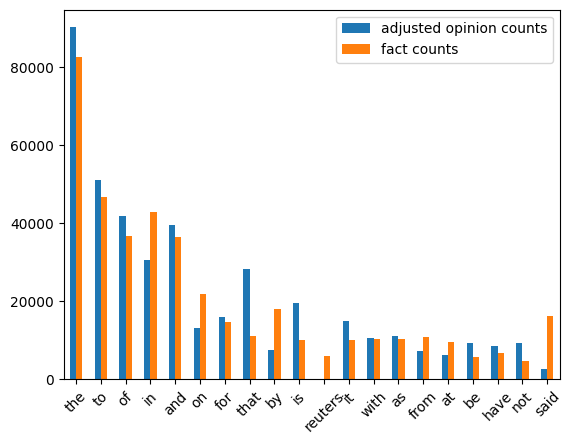

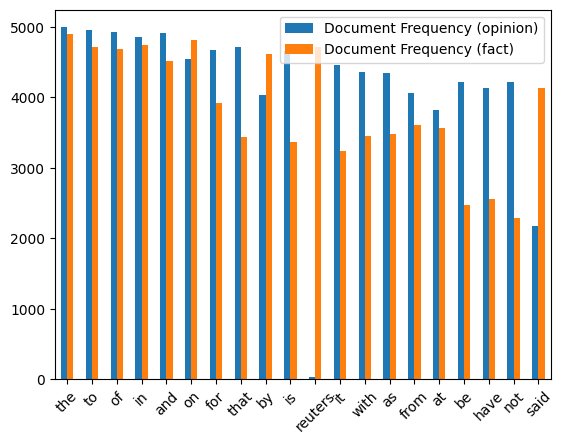

In [ ]:
top_feat=[(feature_names[feature_index], info_gain_scores[feature_index]) for feature_index in top_features]
tf=pd.DataFrame(top_feat, columns=["names","InfoGainScores"])

word_counts_graph(tf.names)
doc_freq_graph(tf.names)

IG_TFIDF=df_from_features(feature_ranking,info_gain_scores,  "IG_TFIDF")

In [ ]:
IG_TFIDF

###Based on Term Frequency

In [ ]:
def info_gain_word(class_vector,pres_vector,entropy=1):
  """
  Calculates the information gain of a word
  
  Class_vector: iterable containing the number of instances of each class
  Pres_vector: iterable containing the number of times a feature is present for each class"""
  N=sum(class_vector) #total number of instances
  No_pres=np.array(class_vector)- np.array(pres_vector)
  sumPres=sum(pres_vector)
  A=pres_vector[0]/sumPres
  B=pres_vector[1]/sumPres
  C=No_pres[0]/(N-sumPres)
  D=No_pres[1]/(N-sumPres)
  try:
    E_pre=-1*(A * math.log2(A)+ B*math.log2(B))
  except:
    E_pre=0
  try:
    E_NP=-1*(C * math.log2(C)+ D*math.log2(D))
  except:
    E_NP=0
  prop=[sumPres/N, 1-(sumPres/N)]
  E_split=(prop[0]*E_pre)+prop[1]*E_NP
  return(entropy-E_split)

def info(prepro_col, target_col,word_list="All",entropy=1, class_vector=[5000,5000]):
  """ Calculate information gain for each word in word dictionary
  INPUT: 
  prepro_col: tokenized column
  target_col: label column
  word_list: a list of words to calculate the information gain for
  
  """
  ig_dict = {}
  word_dict= doc_freq_dict2(prepro_col, word_list) #gives frequency of words in word list
  class_dict_nest=dict()
  for class_ in target_col.unique():
    class_dict_nest[class_]= doc_freq_dict2(prepro_col[target_col==class_], word_list) #analyses the documents 1 class at a time

  for word in word_dict:
  #making a class dictionary
    word_class_dict = {}
    for class_ in target_col.unique():
      try:
        word_class_dict[class_]=class_dict_nest[class_][word]
      except:
        word_class_dict[class_]=0 #not present
      
    pres_vector=[v for (k,v) in word_class_dict.items()]
    
    

    ig_dict[word] = info_gain_word(class_vector, pres_vector, entropy=entropy)
    
  return(sorted(ig_dict.items(), key=lambda x: x[1], reverse=True))

IG_gain=info(df.tokenized,df.label)



In [ ]:
feature_names

array(['00', '000', '0000', ..., 'сhina', 'ﬁx', 'ﬁxed'], dtype=object)

In [ ]:
IG_gain2=[(name, score) for (name, score) in IG_gain if name in feature_names]

In [ ]:
##outer join

,Document Frequency (opinion),Document Frequency (fact)
reuters,27,4711
editing,9,4216
reporting,230,4152
trump,3169,527
what,3250,708
photo,88,1942
file,66,1863
if,3307,900
coronavirus,13,1621
do,2780,552


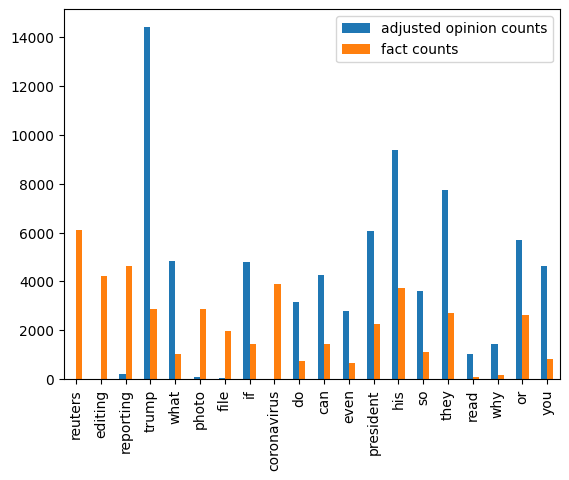

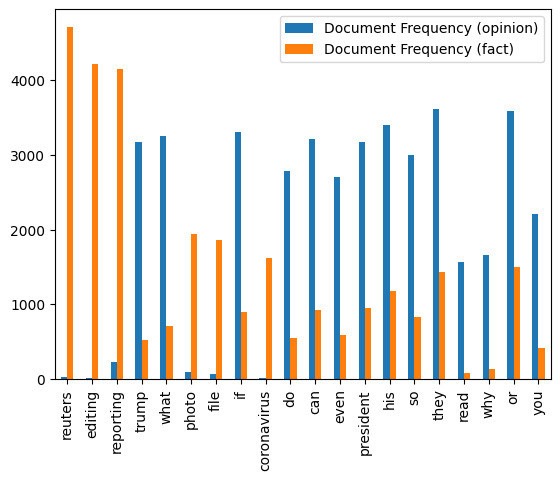

In [ ]:
ig=pd.DataFrame(IG_gain2[:20], columns=["names","IG_score"])
word_counts_graph(ig.names, rot=90)
doc_freq_graph(ig.names, rot=90)

In [ ]:
IG_simple=pd.DataFrame(IG_gain2, columns=["names", "IG_simple"])
IG_simple["rank_IG_simple"]=range(1, len(IG_gain2)+1)
IG_simple

#scores_total=

,names,IG_simple,rank_IG_simple
0,reuters,0.814471,1
1,editing,0.659797,2
2,reporting,0.525979,3
3,trump,0.233568,4
4,what,0.207200,5
...,...,...,...
55027,variability,0.000000,55028
55028,melancholy,0.000000,55029
55029,tallahassee,0.000000,55030
55030,rib,0.000000,55031


In [ ]:
scores_total = pd.merge(IG_TFIDF, IG_simple, on='names', how='left')
 
# display dataframe
scores_total


,names,IG_TFIDF,rank_IG_TFIDF,IG_simple,rank_IG_simple
0,the,0.690229,1,0.007564,1432.0
1,to,0.679046,2,0.013786,743.0
2,of,0.673198,3,0.011342,918.0
3,in,0.667291,4,0.002313,4443.0
4,and,0.667158,5,0.021607,457.0
...,...,...,...,...,...
58047,cyberintelligence,0.000069,58048,0.000100,41960.0
58048,cyberscapes,0.000069,58049,0.000100,38499.0
58049,ndaa,0.000069,58050,0.000100,36097.0
58050,nda,0.000069,58051,0.000100,36182.0


## Chisq

[Good methodology for choosing tfidf before chisq](https://www.researchgate.net/publication/340573511_Improve_the_Accuracy_of_Support_Vector_Machine_Using_Chi_Square_Statistic_and_Term_Frequency_Inverse_Document_Frequency_on_Movie_Review_Sentiment_Analysis/fulltext/5e916eaf299bf130798fb4ff/Improve-the-Accuracy-of-Support-Vector-Machine-Using-Chi-Square-Statistic-and-Term-Frequency-Inverse-Document-Frequency-on-Movie-Review-Sentiment-Analysis.pdf)

In [ ]:
# number of top features based on Chi-square statistics
N = 20

# tfidf chosen as it takes into account varying lengths of documents (opinion vs fact)
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df['all_text'])

y = df['label'].factorize()[0] 

chi2_scores, p_values = chi2(X, y)

# Features ranked in descending order based on Chi-square stat
feature_ranking = chi2_scores.argsort()[::-1]

# stores the features of the top N places
top_features = feature_ranking[:N]

feature_names_chisq = vectorizer.get_feature_names_out() # Makes readable

for feature_index in top_features:
    print(feature_names_chisq[feature_index], chi2_scores[feature_index])



trump 240.14173510482965
reuters 166.80848646869157
that 163.8315915390462
china 139.1622622992782
coronavirus 131.95182006322955
mr 103.23025984040177
said 101.5157473328523
you 93.17298451580714
virus 93.10393703674083
his 91.84839527363675
is 90.82864185305579
editing 87.17093840936212
he 85.76783165096171
reporting 82.5280096217599
outbreak 80.01190696016076
flights 78.91423451556145
the 78.86045610670507
they 77.05022405596327
billion 76.54343177130716
what 75.3968550327011


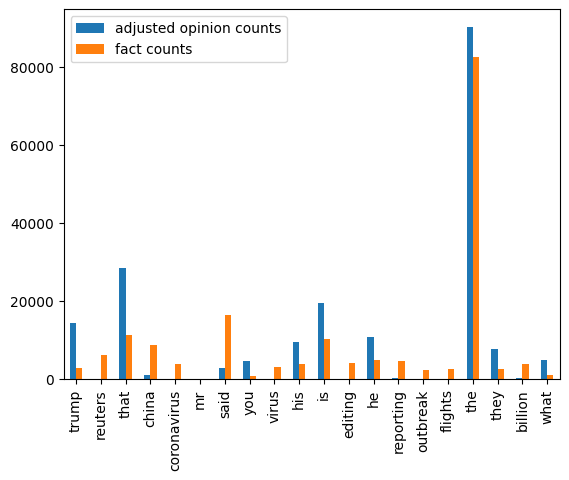

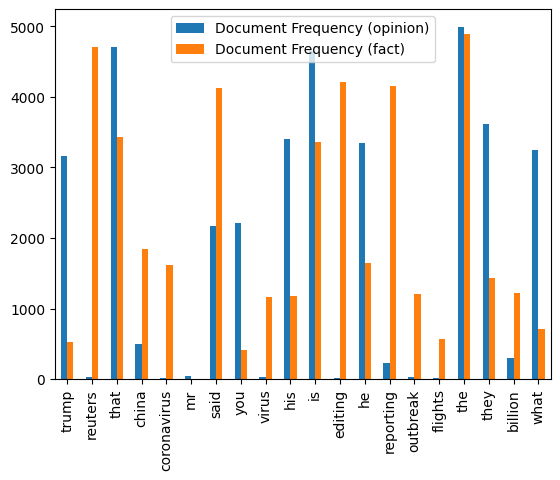

In [ ]:
top_feat=[(feature_names[feature_index], info_gain_scores[feature_index]) for feature_index in top_features]
tf=pd.DataFrame(top_feat, columns=["names","InfoGainScores"])

word_counts_graph(tf.names, rot=90)
doc_freq_graph(tf.names, rot=90)
chi2=df_from_features(feature_ranking, chi2_scores, "chi2")

In [ ]:
scores_total = pd.merge(scores_total, chi2, on='names', how="left")
scores_total

,names,IG_TFIDF,rank_IG_TFIDF,IG_simple,rank_IG_simple,A2,rank_A2,chi2,rank_chi2
0,the,0.690229,1,0.007564,1432.0,0.076552,1,78.860456,17
1,to,0.679046,2,0.013786,743.0,0.046242,4,49.900181,37
2,of,0.673198,3,0.011342,918.0,0.039248,5,44.271118,50
3,in,0.667291,4,0.002313,4443.0,0.001009,2058,0.032447,53608
4,and,0.667158,5,0.021607,457.0,0.038825,6,45.197159,48
...,...,...,...,...,...,...,...,...,...
58047,cyberintelligence,0.000069,58048,0.000100,41960.0,0.000010,52417,0.051188,49610
58048,cyberscapes,0.000069,58049,0.000100,38499.0,0.000019,41036,0.094338,37963
58049,ndaa,0.000069,58050,0.000100,36097.0,0.000036,29917,0.180778,26740
58050,nda,0.000069,58051,0.000100,36182.0,0.000011,51279,0.054502,48447


In [ ]:
import csv

# Number of top features
N = 20

# Threshold definitions
min_df = 2   # exclude terms that appear in less than min_df documents
max_df = 0.8 # exclude terms that appear in more than max_df * total_documents

# tfidf chosen - allows for differing lengths
vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)

X = vectorizer.fit_transform(df['all_text'])

y = df['label'].factorize()[0]

chi2_scores, p_values = chi2(X, y)

feature_ranking = chi2_scores.argsort()[::-1]

# Select the top N features with the highest Chi-square statistics
top_features_chisq = feature_ranking[:N]

# Extract the feature names from the vocabulary
feature_names_chisq = vectorizer.get_feature_names_out()

# Print the top N features and their corresponding Chi-square statistics
with open('top_features_chisq.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['word', 'chisq'])
    for feature_index in top_features_chisq:
        writer.writerow([feature_names_chisq[feature_index], chi2_scores[feature_index]])

In [ ]:
N = 25

trace = go.Bar(x=feature_names[top_features[:N]],
               y=chi2_scores[top_features_chisq[:N]],
               marker=dict(color='rgb(158,202,225)',
                           line=dict(color='rgb(8,48,107)', width=1.5)),
               opacity=0.6)

layout = go.Layout(title='Top {} Features Based on Chi-square Statistics'.format(N),
                   xaxis=dict(title='Features'),
                   yaxis=dict(title='Chi-square Statistics'))

fig = go.Figure(data=[trace], layout=layout)
fig.show()

## Document Frequency Thresholding

In [ ]:
# Number of top features
N = 20

# Threshold definitions
min_df = 2   # exclude terms that appear in less than min_df documents
max_df = 0.8 # exclude terms that appear in more than max_df * total_documents

# Playing around with these filters can help show which words continue to show

# tfidf chosen - allows for differing lengths
vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)

X = vectorizer.fit_transform(df['all_text'])

y = df['label'].factorize()[0]

chi2_scores, p_values = chi2(X, y)

feature_ranking = chi2_scores.argsort()[::-1]

# Select the top N features with the highest Chi-square statistics
top_features = feature_ranking[:N]

# Extract the feature names from the vocabulary
feature_names = vectorizer.get_feature_names_out()

# Print the top N features and their corresponding Chi-square statistics
for feature_index in top_features:
    print(feature_names[feature_index], chi2_scores[feature_index])


In [ ]:
top_feat=[(feature_names[feature_index], info_gain_scores[feature_index]) for feature_index in top_features]
tf=pd.DataFrame(top_feat, columns=["names","InfoGainScores"])

word_counts_graph(tf.names, rot=90)
doc_freq_graph(tf.names, rot=90)

In [ ]:
import csv

# Number of top features
N = 20

# Threshold definitions
min_df = 2   # exclude terms that appear in less than min_df documents
max_df = 0.8 # exclude terms that appear in more than max_df * total_documents

# tfidf chosen - allows for differing lengths
vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)

X = vectorizer.fit_transform(df['all_text'])

y = df['label'].factorize()[0]

chi2_scores, p_values = chi2(X, y)

feature_ranking = chi2_scores.argsort()[::-1]

# Select the top N features with the highest Chi-square statistics
top_features_dft = feature_ranking[:N]

# Extract the feature names from the vocabulary
feature_names_dft = vectorizer.get_feature_names_out()

# Print the top N features and their corresponding Chi-square statistics
with open('top_features_dft.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['word', 'chisq'])
    for feature_index in top_features_dft:
        writer.writerow([feature_names_dft[feature_index], chi2_scores[feature_index]])


In [ ]:
N = 25

trace = go.Bar(x=feature_names[top_features[:N]],
               y=chi2_scores[top_features[:N]],
               marker=dict(color='rgb(158,202,225)',
                           line=dict(color='rgb(8,48,107)', width=1.5)),
               opacity=0.6)

layout = go.Layout(title='Top {} Features Based on Document Frequency Thresholding'.format(N),
                   xaxis=dict(title='Features'),
                   yaxis=dict(title='Chi-square Statistics'))

fig = go.Figure(data=[trace], layout=layout)
fig.show()

## Accuracy2

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2

min_df = 3   # exclude terms that appear in less than min_df documents
max_df = 0.3 # exclude terms that appear in more than max_df * total_documents

# Playing around with these filters can help show which words continue to show

# tfidf chosen - allows for differing lengths
#vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)
vectorizer = TfidfVectorizer() #want a broad comparison

X = vectorizer.fit_transform(df['all_text'])

# Convert the class labels to integers
y = df['label'].factorize()[0]

chi2_scores, p_values = chi2(X, y)

feature_names = vectorizer.get_feature_names_out()

accuracy2_scores = []
for i, feature in enumerate(feature_names):
    # find the frequency
    freq_pos = X[y == 1, i].sum()
    freq_neg = X[y == 0, i].sum()
    
    # find the proportion
    prop_pos = freq_pos / (y == 1).sum()
    prop_neg = freq_neg / (y == 0).sum()
    
    # calculate accuracy2 score
    accuracy2 = abs(prop_pos - prop_neg)
    accuracy2_scores.append(accuracy2)
    
# ranks based on descending
feature_ranking = sorted(range(len(accuracy2_scores)), key=lambda i: accuracy2_scores[i], reverse=True)

N = 20
top_features = feature_ranking[:N]

# Print the top N features and their corresponding accuracy2 scores
for feature_index in top_features:
    print(feature_names[feature_index], accuracy2_scores[feature_index])


the 0.07655150643823674
trump 0.06277855779279959
that 0.05844223728815055
to 0.04624202306194053
of 0.03924775769538809
and 0.03882540182945113
is 0.03826245521621742
china 0.037213356437843875
reuters 0.034099657917262396
said 0.03252553321604842
he 0.031165047483218272
his 0.03032453584283083
coronavirus 0.02684304754932035
it 0.024498461212133116
they 0.024471601216651397
this 0.023116352531614322
president 0.023013228600038047
you 0.022988621230132546
mr 0.020866763048675855
not 0.02076385216091676


,Document Frequency (opinion),Document Frequency (fact)
the,4992,4891
trump,3169,527
that,4715,3438
to,4950,4712
of,4920,4683
and,4904,4516
is,4649,3362
china,496,1851
reuters,27,4711
said,2173,4124


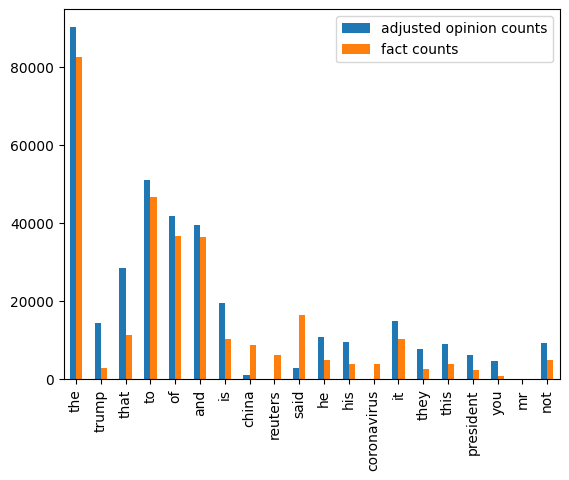

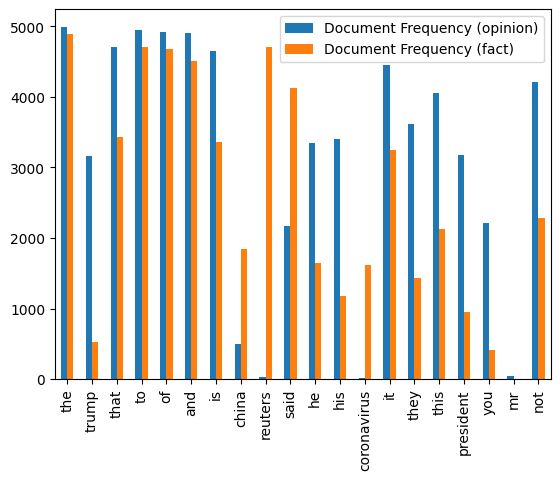

In [ ]:
accuracy2=df_from_features(feature_ranking,accuracy2_scores, "A2")

word_counts_graph(accuracy2.names[:20], rot=90)
doc_freq_graph(accuracy2.names[:20], rot=90)






In [ ]:
N = 25

trace = go.Bar(x=feature_names[top_features[:N]],
               y=chi2_scores[top_features[:N]],
               marker=dict(color='rgb(158,202,225)',
                           line=dict(color='rgb(8,48,107)', width=1.5)),
               opacity=0.6)

layout = go.Layout(title='Top {} Features Based on Accuracy2'.format(N),
                   xaxis=dict(title='Features'),
                   yaxis=dict(title='Chi-square Statistics'))

fig = go.Figure(data=[trace], layout=layout)
fig.show()

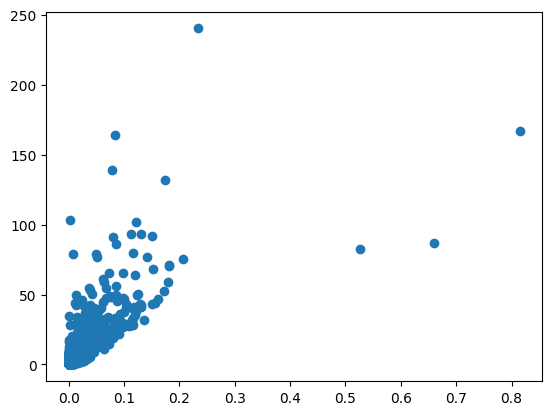

In [ ]:
plt.scatter(scores_total.IG_simple, scores_total.chi2)
#plt.scatter(scores_total.rank_IG_TFIDF, scores_total.rank_A2)

In [ ]:
scores_total = pd.merge(scores_total, accuracy2, on='names', how="left")


In [ ]:
scores_total

,names,IG_TFIDF,rank_IG_TFIDF,IG_simple,rank_IG_simple,A2,rank_A2,chi2,rank_chi2
0,the,0.690229,1,0.007564,1432.0,0.076552,1,78.860456,17
1,to,0.679046,2,0.013786,743.0,0.046242,4,49.900181,37
2,of,0.673198,3,0.011342,918.0,0.039248,5,44.271118,50
3,in,0.667291,4,0.002313,4443.0,0.001009,2058,0.032447,53608
4,and,0.667158,5,0.021607,457.0,0.038825,6,45.197159,48
...,...,...,...,...,...,...,...,...,...
58047,cyberintelligence,0.000069,58048,0.000100,41960.0,0.000010,52417,0.051188,49610
58048,cyberscapes,0.000069,58049,0.000100,38499.0,0.000019,41036,0.094338,37963
58049,ndaa,0.000069,58050,0.000100,36097.0,0.000036,29917,0.180778,26740
58050,nda,0.000069,58051,0.000100,36182.0,0.000011,51279,0.054502,48447


<ipython-input-83-a7c315a0439d>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-83-a7c315a0439d>:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-83-a7c315a0439d>:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-83-a7c315a0439d>:18: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



TypeError: ignored

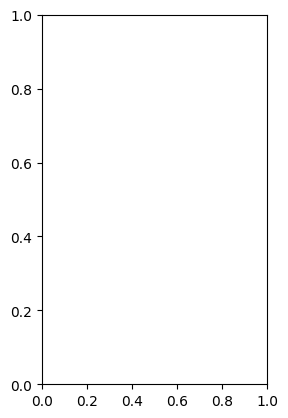

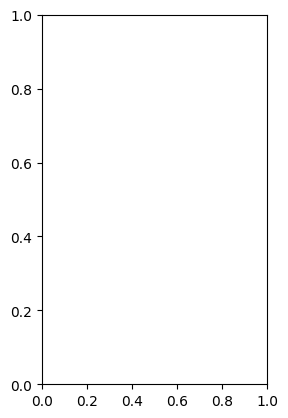

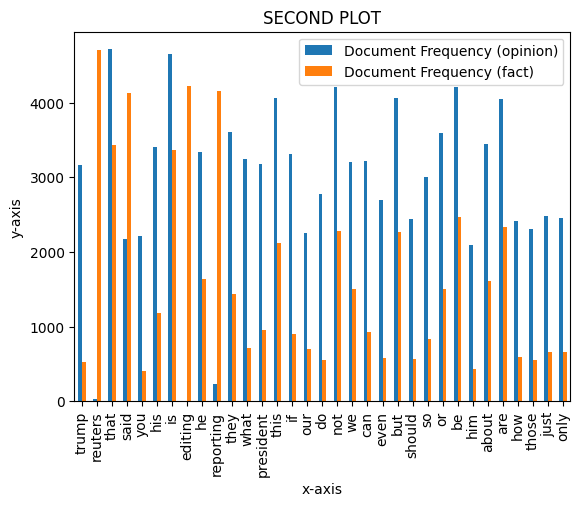

In [ ]:
k=100
a1=scores_total[scores_total["rank_IG_TFIDF"]<k ]
a2=a1[ scores_total["rank_IG_simple"]<k ]#& 
a3=a2[scores_total["rank_chi2"]<k]
a4=a3[scores_total["rank_A2"]<k]
a4=a4.sort_values(by=["rank_chi2"])
             

# using subplot function and creating plot one
plt.subplot(1, 2, 1)  # row 1, column 2, count 1

word_counts_graph(a4.names, rot=90)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
 
# using subplot function and creating plot two
# row 1, column 2, count 2
plt.subplot(1, 2, 2)
 
# g is for green color
doc_freq_graph(a4.names, rot=90)
plt.title('SECOND PLOT')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
 
# space between the plots
plt.tight_layout(4)
 
# show plot
plt.show()


a4.names[:10]


In [ ]:
scores_total[scores_total.rank_chi2<50].sort_values("chi2")

,names,IG_TFIDF,rank_IG_TFIDF,IG_simple,rank_IG_simple,A2,rank_A2,chi2,rank_chi2
11,it,0.568395,12,0.062905,106.0,0.024498,14,44.373122,49
4,and,0.667158,5,0.021607,457.0,0.038825,6,45.197159,48
239,jan,0.098771,240,0.087181,57.0,0.010524,84,45.452384,47
1661,eu,0.019073,1662,0.023912,415.0,0.009320,98,46.199951,46
58,can,0.309653,59,0.162206,11.0,0.014376,46,46.549202,45
157,democrats,0.132450,158,0.100832,43.0,0.013538,52,46.859286,44
110,house,0.176801,111,0.098538,47.0,0.014767,43,47.513230,43
191,friday,0.116277,192,0.067270,94.0,0.011545,66,47.685961,42
297,voters,0.083450,298,0.076361,76.0,0.011522,67,47.952138,41
223,impeachment,0.103194,224,0.074248,78.0,0.014692,44,48.731419,40


In [ ]:
a4.head(10)

,names,IG_TFIDF,rank_IG_TFIDF,IG_simple,rank_IG_simple,A2,rank_A2,chi2,rank_chi2
10,reuters,0.589690,11,0.814471,1.0,0.034100,9,166.808486,2
19,said,0.490615,20,0.122359,25.0,0.032526,10,101.515747,7
40,his,0.365007,41,0.149934,14.0,0.030325,12,91.848395,10
26,editing,0.464186,27,0.659797,2.0,0.017479,31,87.170938,12
27,reporting,0.454752,28,0.525979,3.0,0.017893,28,82.528010,14
32,they,0.399574,33,0.141047,16.0,0.024472,15,77.050224,18
47,what,0.329523,48,0.207200,5.0,0.019725,23,75.396855,20
46,president,0.330110,47,0.152370,13.0,0.023013,17,68.199555,23
24,this,0.480309,25,0.119060,28.0,0.023116,16,63.942933,26
43,if,0.343476,44,0.180004,8.0,0.017559,30,59.098908,28


In [ ]:
scores_total

# Stopwords And Punctuation Analysis

In [ ]:
stopwords_list = stopwords.words('english')
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

,Document Frequency (opinion),Document Frequency (fact)
his,3406,1176
they,3612,1438
what,3250,708
this,4060,2121
if,3307,900
not,4212,2286


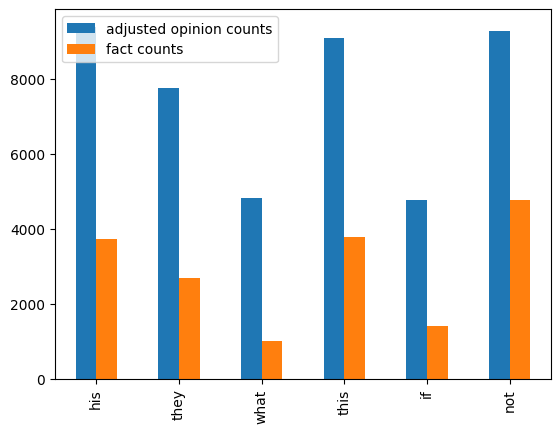

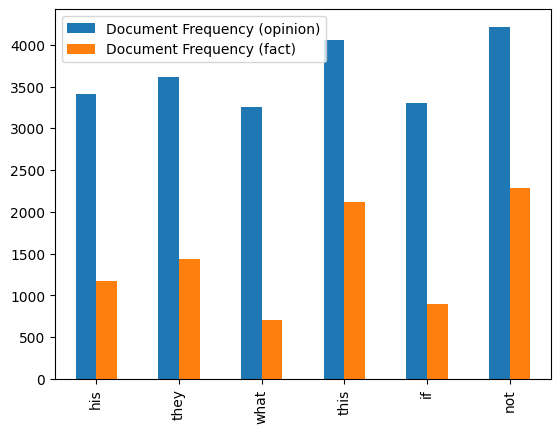

In [ ]:
stopwords

#grid of stopwords and various scores
sw_important=list()
for name in a4.names:
  if name in stopwords_list:
    sw_important.append(name)


word_counts_graph(sw_important, rot=90)
doc_freq_graph(sw_important, rot=90)

In [ ]:
scores_total[scores_total.names == 'trump']#, 'me', 'we', 'us', 'our', 'myself']] his, they, what, this, if, not

,names,IG_TFIDF,rank_IG_TFIDF,IG_simple,rank_IG_simple,A2,rank_A2,chi2,rank_chi2
54,trump,0.314411,55,0.233568,4.0,0.062779,2,240.141735,1
